In [1]:
import os
import pandas as pd

# -------------------------------
# Paths - update these if needed
# -------------------------------
chest_xray_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"
covid19_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
covid_qu_ex_dir = "/kaggle/input/covid-qu-ex/COVID-QU-Ex"

data = []

# -------------------------------
# 1. Chest X-ray Pneumonia Dataset
# -------------------------------
for split in ["train", "val", "test"]:
    for label in ["PNEUMONIA", "NORMAL"]:
        folder = os.path.join(chest_xray_dir, split, label)
        if not os.path.exists(folder):
            continue
        for img in os.listdir(folder):
            data.append([os.path.join(folder, img), label.lower(), "chest_xray"])

# -------------------------------
# 2. COVID-19 Radiography Database
# -------------------------------
covid_mapping = {
    "COVID": "covid",
    "Viral Pneumonia": "pneumonia",   # merge viral pneumonia into pneumonia
    "Lung_Opacity": "pneumonia",     # can treat as pneumonia
    "Normal": "normal"
}

for folder in os.listdir(covid19_dir):
    if folder not in covid_mapping:
        continue
    label = covid_mapping[folder]
    folder_path = os.path.join(covid19_dir, folder, "images")
    if not os.path.exists(folder_path):  # some versions store images directly
        folder_path = os.path.join(covid19_dir, folder)
    for img in os.listdir(folder_path):
        data.append([os.path.join(folder_path, img), label, "covid19_radiography"])

# -------------------------------
# 3. COVID-QU-Ex Dataset (only COVID-19 extracted)
# -------------------------------
for split in ["train", "val", "test"]:
    covid19_folder = os.path.join(covid_qu_ex_dir, split, "COVID-19")
    if not os.path.exists(covid19_folder):
        continue

    images_path = os.path.join(covid19_folder, "images")
    if os.path.exists(images_path):
        for img in os.listdir(images_path):
            data.append([os.path.join(images_path, img), "covid", "covid_qu_ex"])

# -------------------------------
# Save Combined Dataset to CSV
# -------------------------------
df = pd.DataFrame(data, columns=["filepath", "label", "source"])
df.to_csv("/kaggle/working/combined_dataset.csv", index=False)

print("✅ combined_dataset.csv created with shape:", df.shape)
print(df['label'].value_counts())
print(df['source'].value_counts())

✅ combined_dataset.csv created with shape: (38970, 3)
label
covid        15565
normal       11775
pneumonia    11630
Name: count, dtype: int64
source
covid19_radiography    21165
covid_qu_ex            11949
chest_xray              5856
Name: count, dtype: int64


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --------------------
# 1. Load combined dataset
# --------------------
df = pd.read_csv("/kaggle/working/combined_dataset.csv")
df = df.rename(columns={"filepath": "file_path"})


# Split train, val, test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

# --------------------
# 2. Image generators (with basic augmentation)
# --------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_path', y_col='label',
    target_size=(224,224), class_mode='categorical',
    batch_size=32, shuffle=True
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df, x_col='file_path', y_col='label',
    target_size=(224,224), class_mode='categorical',
    batch_size=32, shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df, x_col='file_path', y_col='label',
    target_size=(224,224), class_mode='categorical',
    batch_size=32, shuffle=False
)

2025-08-25 03:12:58.257275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756091578.426293      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756091578.480612      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train size: 28058
Val size: 3118
Test size: 7794
Found 28058 validated image filenames belonging to 3 classes.
Found 3118 validated image filenames belonging to 3 classes.
Found 7794 validated image filenames belonging to 3 classes.


In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


# --------------------
# 3. Build DenseNet121 model
# --------------------
base_model = DenseNet121(
    weights='/kaggle/input/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',  # must be a direct .h5 weight file
    include_top=False,
    input_shape=(224, 224, 3)
)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Increased neurons
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # Freeze base DenseNet121 first

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

I0000 00:00:1756091697.441645      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_df['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['label'])
class_weights = dict(zip(range(len(classes)), weights))

print("Class weights:", class_weights)

Class weights: {0: 0.8345379375985247, 1: 1.1031689863961627, 2: 1.117003065408655}


In [6]:
# --------------------
# Phase 1: Train only top layers
# --------------------
print("Phase 1: Training top layers only...")
EPOCHS_PHASE1 = 15
BATCH_SIZE = 16  # Reduced batch size for better gradients

# Enhanced callbacks
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7, verbose=1)
]

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_phase1,
    verbose=1
)


Phase 1: Training top layers only...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1756091724.483403      58 service.cc:148] XLA service 0x798868001b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756091724.484399      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756091727.441756      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/877 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.3828 - loss: 2.3279 - precision: 0.3852 - recall: 0.3672   

I0000 00:00:1756091739.850874      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


877/877 ━━━━━━━━━━━━━━━━━━━━ 572s 611ms/step - accuracy: 0.5563 - loss: 1.6788 - precision: 0.5713 - recall: 0.5191 - val_accuracy: 0.7688 - val_loss: 1.0491 - val_precision: 0.7876 - val_recall: 0.7457 - learning_rate: 1.0000e-04
Epoch 2/15
877/877 ━━━━━━━━━━━━━━━━━━━━ 357s 407ms/step - accuracy: 0.7143 - loss: 1.1846 - precision: 0.7311 - recall: 0.6888 - val_accuracy: 0.7915 - val_loss: 0.9394 - val_precision: 0.8124 - val_recall: 0.7720 - learning_rate: 1.0000e-04
Epoch 3/15
877/877 ━━━━━━━━━━━━━━━━━━━━ 360s 410ms/step - accuracy: 0.7370 - loss: 1.0783 - precision: 0.7566 - recall: 0.7128 - val_accuracy: 0.8040 - val_loss: 0.8863 - val_precision: 0.8256 - val_recall: 0.7806 - learning_rate: 1.0000e-04
Epoch 4/15
877/877 ━━━━━━━━━━━━━━━━━━━━ 356s 406ms/step - accuracy: 0.7551 - loss: 1.0045 - precision: 0.7749 - recall: 0.7292 - val_accuracy: 0.8165 - val_loss: 0.8391 - val_precision: 0.8351 - val_recall: 0.7960 - learning_rate: 1.0000e-04
Epoch 5/15
877/877 ━━━━━━━━━━━━━━━━━━━━ 355

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
# --------------------
# Phase 2: Fine-tune entire model
# --------------------
print("Phase 2: Fine-tuning entire model...")

# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

# Use much lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Much lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

EPOCHS_PHASE2 = 20

# Custom learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8, verbose=1),
    LearningRateScheduler(scheduler, verbose=1)
]

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE2,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks_phase2,
    verbose=1
)

Phase 2: Fine-tuning entire model...

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 653s 537ms/step - accuracy: 0.7679 - loss: 0.8067 - precision: 0.7899 - recall: 0.7420 - val_accuracy: 0.8980 - val_loss: 0.4915 - val_precision: 0.9085 - val_recall: 0.8881 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 366s 417ms/step - accuracy: 0.8720 - loss: 0.5557 - precision: 0.8828 - recall: 0.8599 - val_accuracy: 0.8897 - val_loss: 0.5003 - val_precision: 0.8975 - val_recall: 0.8842 - learning_rate: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 368s 419ms/step - accuracy: 0.9004 - loss: 0.4894 - precision: 0.9090 - recall: 0.8912 - val_accuracy: 0.8980 - val_loss: 0.4906 - val_precision: 0.9030 - val_recall: 0.8900 - learning_rate: 1.0000e-

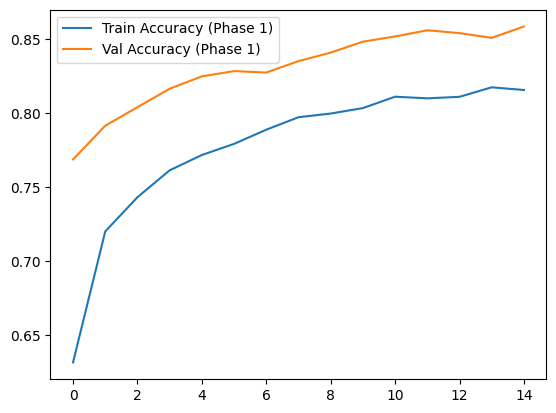

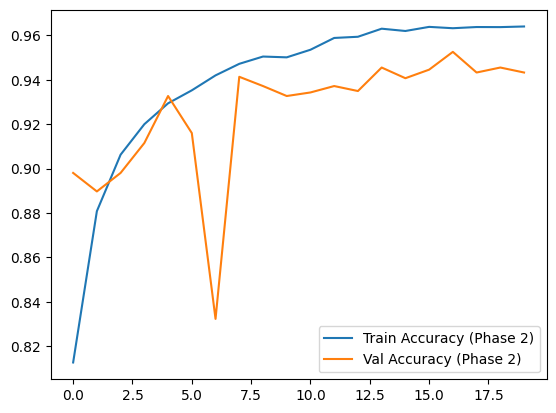

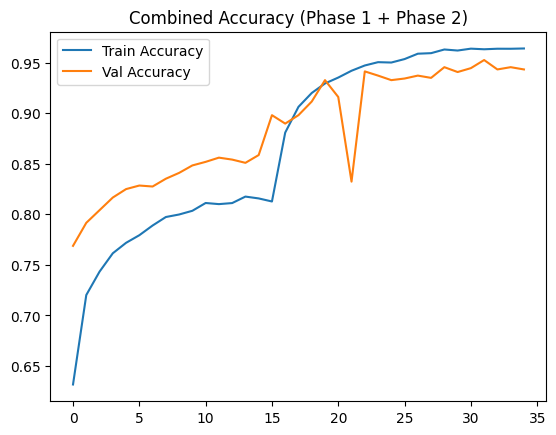

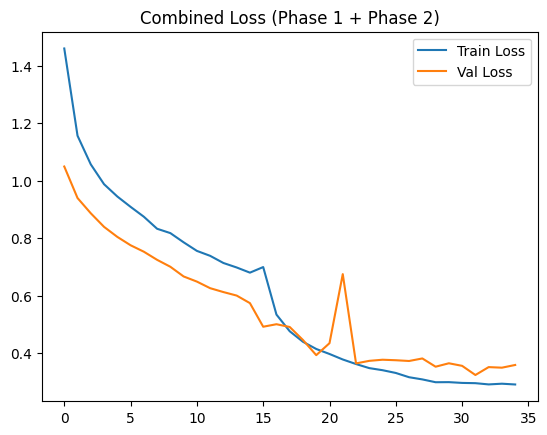

In [8]:
import matplotlib.pyplot as plt

# Phase 1 plots
plt.plot(history_phase1.history['accuracy'], label='Train Accuracy (Phase 1)')
plt.plot(history_phase1.history['val_accuracy'], label='Val Accuracy (Phase 1)')
plt.legend()
plt.show()

# Phase 2 plots
plt.plot(history_phase2.history['accuracy'], label='Train Accuracy (Phase 2)')
plt.plot(history_phase2.history['val_accuracy'], label='Val Accuracy (Phase 2)')
plt.legend()
plt.show()

acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title("Combined Accuracy (Phase 1 + Phase 2)")
plt.legend()
plt.show()

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Combined Loss (Phase 1 + Phase 2)")
plt.legend()
plt.show()


In [9]:
# --------------------
# 5. Evaluate model
# --------------------

loss, acc, precision, recall = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Get true labels
y_true = test_df['label'].values

# Predict and map to label strings
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Map numeric predictions to string labels
index_to_label = {v: k for k, v in test_gen.class_indices.items()}
y_pred_labels = [index_to_label[i] for i in y_pred_classes]

# Class names
target_names = list(test_gen.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels, labels=target_names)
print("\nConfusion Matrix:")
print(cm)


244/244 ━━━━━━━━━━━━━━━━━━━━ 94s 384ms/step - accuracy: 0.9525 - loss: 0.3102 - precision: 0.9539 - recall: 0.9523
Test Loss: 0.3095
Test Accuracy: 0.9529
Test Precision: 0.9542
Test Recall: 0.9527
244/244 ━━━━━━━━━━━━━━━━━━━━ 52s 167ms/step

Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.97      0.98      3113
      normal       0.89      0.98      0.93      2355
   pneumonia       0.96      0.90      0.93      2326

    accuracy                           0.95      7794
   macro avg       0.95      0.95      0.95      7794
weighted avg       0.96      0.95      0.95      7794


Confusion Matrix:
[[3012   62   39]
 [   1 2313   41]
 [   2  222 2102]]


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Reshape, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model

# --------------------
# DenseNet121 + Transformer
# --------------------

def create_hybrid_model():
    base_model = DenseNet121(
        weights='/kaggle/input/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    for layer in base_model.layers:
        layer.trainable = False
    
    features = base_model.output  
    
    # --------------------
    # Adding Transformer
    # --------------------
    

    x = Reshape((49, 1024))(features)  
    

    positions = tf.range(start=0, limit=49, delta=1)
    position_embedding = tf.keras.layers.Embedding(
        input_dim=49, output_dim=1024
    )(positions)
    x = x + position_embedding
    
    for _ in range(2):  # 2nd transformer

        attn_output = MultiHeadAttention(
            num_heads=8, key_dim=128  
        )(x, x)
        x = LayerNormalization()(x + attn_output)
        

        ffn = Dense(1024, activation='relu')(x)
        ffn = Dense(1024)(ffn)
        x = LayerNormalization()(x + ffn)
    

    x = GlobalAveragePooling2D()(Reshape((7, 7, 1024))(x))
    

    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(x)
    
    hybrid_model = Model(inputs=base_model.input, outputs=output)
    
    return hybrid_model

hybrid_model = create_hybrid_model()

In [ ]:
# freeze cnn, train only transformer
hybrid_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

history_hybrid = hybrid_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20, 
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 439s 452ms/step - accuracy: 0.7124 - loss: 1.3575 - precision: 0.7268 - recall: 0.6897 - val_accuracy: 0.7543 - val_loss: 1.3008 - val_precision: 0.7647 - val_recall: 0.7431
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 374s 427ms/step - accuracy: 0.8396 - loss: 1.0033 - precision: 0.8517 - recall: 0.8286 - val_accuracy: 0.8669 - val_loss: 0.8847 - val_precision: 0.8773 - val_recall: 0.8550
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 370s 422ms/step - accuracy: 0.8571 - loss: 0.9193 - precision: 0.8688 - recall: 0.8470 - val_accuracy: 0.8573 - val_loss: 0.8874 - val_precision: 0.8658 - val_recall: 0.8525
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 370s 422ms/step - accuracy: 0.8720 - loss: 0.8501 - precision: 0.8808 - recall: 0.8630 - val_accuracy: 0.8977 - val_loss: 0.7693 - val_precision: 0.9067 - val_recall: 0.8884
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 370s 422ms/step - accuracy: 0.8796 - loss: 0.7927 - precision: 0.8876 - recall: 0.8704 - val_accuracy: 0

In [12]:
# Compare Hybrid Model vs Pure DenseNet
hybrid_results = hybrid_model.evaluate(test_gen)
print(f"Hybrid Model Accuracy: {hybrid_results[1]:.4f}")
print(f"Original DenseNet Accuracy: 0.9539")

if hybrid_results[1] > 0.959:  # Continue only if significant improvement
    print("✅ Hybrid model performs better, continue optimization!")
else:
    print("⚠️  Hybrid model shows no significant improvement, revert to original architecture")

244/244 ━━━━━━━━━━━━━━━━━━━━ 46s 188ms/step - accuracy: 0.9357 - loss: 0.2307 - precision: 0.9383 - recall: 0.9340
Hybrid Model Accuracy: 0.9355
Original DenseNet Accuracy: 0.9539
⚠️  Hybrid model shows no significant improvement, revert to original architecture
